In [1]:
# # force a reload of dl_models module without restarting the kernel by using Python’s built‑in importlib.reload
# import importlib
# import dl_models
# importlib.reload(dl_models)

In [2]:
import pandas as pd
import numpy as np
from sql_export import sql_connection, sql_connection_close
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from dotenv import load_dotenv
# from concurrent import futures
import matplotlib.pyplot as plt
from azure_blob_dataset import AzureBlobDataset
import random
from skimage.transform import rotate
from dl_models import CNNFromScratch, get_efficientnet, get_vit, get_resnet
import time
import torch.optim as optim
import torch.nn as nn
from rotate import RandomRotation
import math



load_dotenv()

True

## Set PATH for Azure SQL in Jupyter environment

In [3]:
# Set Apple Silicon paths (for M1/M2 Macs)
# For some reason we need to manually set paths for the odbcinst file so jupyter file can connect to Azure SQL
# Did not need to do this for python code

os.environ['ODBCSYSINI'] = os.getenv('ETC')
os.environ['ODBCINSTINI'] = os.getenv("INI")
os.environ['DYLD_LIBRARY_PATH'] = os.getenv("LIB")

In [4]:
!odbcinst -q -d -n "ODBC Driver 18 for SQL Server"

[ODBC Driver 18 for SQL Server]
Description=Microsoft ODBC Driver 18 for SQL Server
Driver=/opt/homebrew/lib/libmsodbcsql.18.dylib
UsageCount=2


## Azure SQL Database Retrieval to memory

In [5]:
sql_connection_close()
sql_query = "SELECT * FROM dbo.galaxy_target_values"
conn, cursor = sql_connection()
target_df = pd.read_sql(sql_query, conn)
target_df
sql_connection_close()

Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation

SQL connection closed.
Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation



/var/folders/51/q7wk1sc54ms0xz7vq4j4k4g80000gn/T/ipykernel_76287/3625703550.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  target_df = pd.read_sql(sql_query, conn)


Connection to SQL server successful.
SQL Server version:  Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Feb  9 2025 20:57:20 
	Copyright (C) 2024 Microsoft Corporation

SQL connection closed.


In [6]:
target_df

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,...,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,...,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,...,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


## Transformations

In [7]:
#transforming the images to tensor and normalizing 
transform_training = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(170/424, 240/424), ratio=(1.0, 1.0)), # scale jittering from center cropping
    RandomRotation(angles = [0, 90, 180, 270]),  # rotate the image on 4 quadrant angles
    transforms.RandomHorizontalFlip(p=0.5), # flip image about horizontal axis 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),                # converts numpy array (H,W,C) in [0,1] to tensor (C,H,W)
    # These values were computed over the ImageNet training set. ImageNet is a huge dataset of natural images and has become the standard benchmark
    #  for many image classification models.
    transforms.Normalize(                 # normalized value = (pixel value - mean)/std
        mean=[0.485, 0.456, 0.406],       # These numbers represent the average pixel intensity (scaled between 0 and 1) for each color channel across the entire ImageNet training set.
        std=[0.229, 0.224, 0.225]         # These values indicate how much the pixel intensities vary (standard deviation) from the mean in each channel.
    )
])

In [8]:
# Define evaluation transforms (deterministic)
transform_eval = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

### Dataset Split (80/10/10)

In [9]:
# doing this makes it easire to lookup target values for corresponding images at O(1) time complexity
# Better integration with DataLoader
target_dict = dict(zip(target_df['GalaxyID'], target_df.drop('GalaxyID', axis=1).values))

In [10]:
full_training_dataset = AzureBlobDataset(train=True, transform=transform_training, target_dict=target_dict, img_size=(424, 424))
full_eval_dataset = AzureBlobDataset(train=True, transform=transform_eval, target_dict=target_dict, img_size=(424, 424))

In [11]:
# Get the same split indices for both (you can generate indices and then create Subset objects)
total_size = len(full_training_dataset)
indices = list(range(total_size))
train_split = int(0.8 * total_size)
val_split = int(0.9 * total_size)


train_dataset = torch.utils.data.Subset(full_training_dataset, indices[:train_split])
val_dataset = torch.utils.data.Subset(full_eval_dataset, indices[train_split:val_split])
test_dataset = torch.utils.data.Subset(full_eval_dataset, indices[val_split:])

print(f"Dataset split: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test.")

# Adjust the batch size based on GPU/CPU memory
batch_size =  128 # Increase this value if memory permits

# Determine the number of available CPU cores and reserve one core for the main process.
num_workers = os.cpu_count() - 1 if os.cpu_count() and os.cpu_count() > 1 else 1


print(f"Using batch_size={batch_size} and num_workers={num_workers}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Dataset split: 49262 train, 6158 val, 6158 test.
Using batch_size=128 and num_workers=10


### Sample view

In [12]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    # Handle case when num_samples is 1
    if num_samples == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        # Get sample
        sample = dataset[i]
        
        # Convert tensor to numpy array and denormalize if needed
        image = sample['image'].numpy()
        
        # For PyTorch CHW format -> Matplotlib HWC format
        if image.shape[0] == 3:  # RGB
            image = image.transpose(1, 2, 0)
        elif image.shape[0] == 1:  # Grayscale
            image = image.squeeze(0)
        
        # Clip values to valid range for display
        image = np.clip(image, 0, 1)
        
        # Show image
        ax.imshow(image)
        ax.axis('off')
        
        # Create title with metadata
        title = f"Galaxy ID: {sample['galaxy_id']}"
        if 'target' in sample:
            title += f"\nTarget: {sample['target'].numpy().round(2)}"
        
        ax.set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

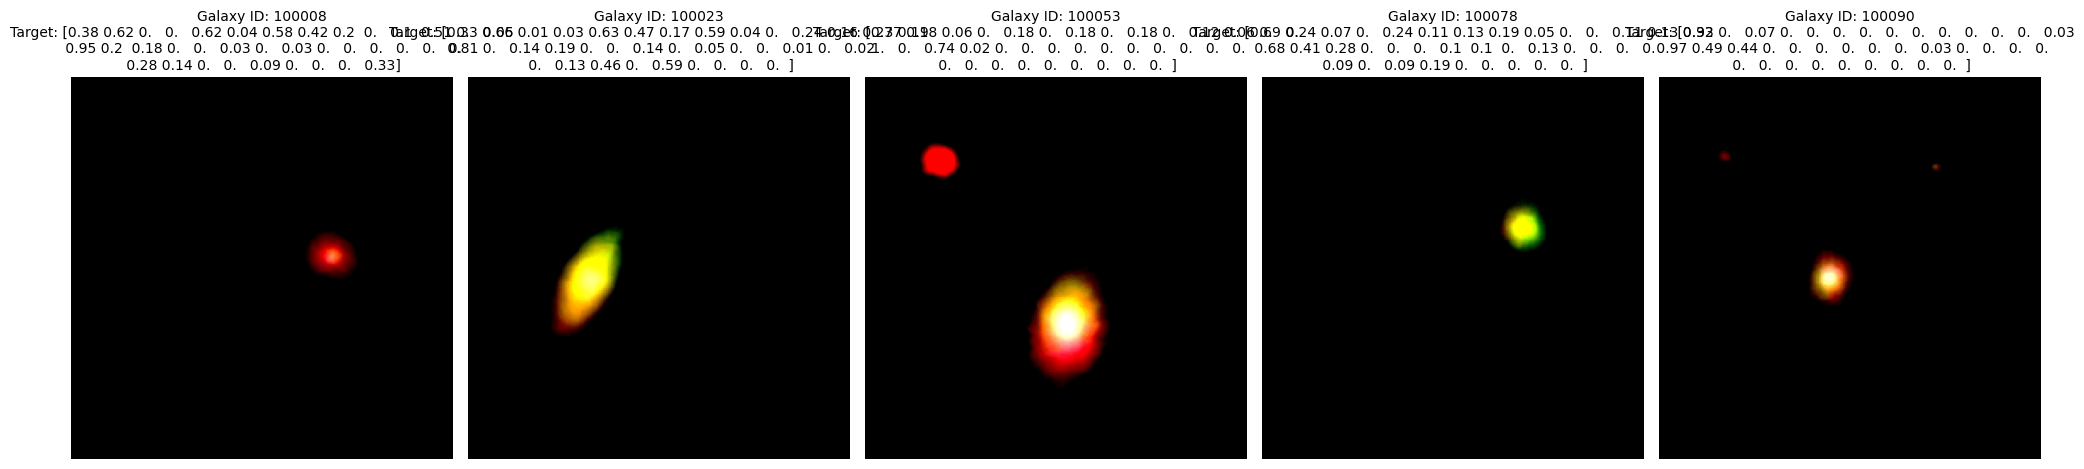

In [13]:
# Visualize first 5 training samples
visualize_samples(train_dataset, num_samples=5)

## DL Model 

### Training Function

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path='best_model.pt'):
    """
    Prints the current epoch, batch progress, and elapsed time.
    Also prints DataLoader settings.
    """
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    # Print DataLoader settings
    print(f"Training DataLoader: batch size = {train_loader.batch_size}, num_workers = {train_loader.num_workers}")
    print(f"Validation DataLoader: batch size = {val_loader.batch_size}, num_workers = {val_loader.num_workers}")
    total_train_batches = len(train_loader)
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        batch_count = 0
        
        print(f"\nStarting Epoch {epoch}/{num_epochs}")
        for batch in train_loader:
            batch_count += 1
            inputs = batch['image'].to(device).contiguous()
            targets = batch['target'].to(device)  # Expected shape: [batch_size, 37]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Print progress every 10 batches
            if batch_count % 10 == 0 or batch_count == total_train_batches:
                print(f"  Epoch {epoch} [{batch_count}/{total_train_batches}] - Batch Loss: {loss.item():.4f}")
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        val_batches = len(val_loader)
        with torch.no_grad():
            for i, batch in enumerate(val_loader, 1):
                inputs = batch['image'].to(device)
                targets = batch['target'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
                # Optionally print progress for validation batches
                if i % 10 == 0 or i == val_batches:
                    print(f"  Validation [{i}/{val_batches}] - Batch Loss: {loss.item():.4f}")
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        elapsed = time.time() - start_time
        print(f"Epoch {epoch} completed in {elapsed:.2f}s | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        
        # Save the best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            print("Validation loss improved; model checkpoint saved.")
    
    return train_losses, val_losses



### Compute Metrics

In [15]:
def compute_metrics(model, data_loader, device):
  
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['image'].to(device).contiguous()
            targets = batch['target'].to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    mse = np.mean((all_preds - all_targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(all_preds - all_targets))
    return mse, rmse, mae

### Plotting Functions


In [16]:
def plot_loss_curves(train_losses, val_losses):

    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    

In [17]:
def plot_scatter_all_channels(actual, predictions, model):

    num_channels = actual.shape[1]
    # Decide grid layout: 7 columns and enough rows to cover all channels
    ncols = 7
    nrows = math.ceil(num_channels / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.flatten()
    
    for ch in range(num_channels):
        ax = axes[ch]
        # Scatter plot for channel ch (index ch)
        ax.scatter(actual[:, ch], predictions[:, ch], alpha=0.5, s=10)
        
        # Plot a reference diagonal line
        min_val = min(actual[:, ch].min(), predictions[:, ch].min())
        max_val = max(actual[:, ch].max(), predictions[:, ch].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
        
        ax.set_title(f'Channel {ch + 1}', fontsize=10)
        ax.set_xlabel('Actual', fontsize=8)
        ax.set_ylabel('Predicted', fontsize=8)
        ax.tick_params(axis='both', labelsize=8)
    
    # Hide any extra subplots (if grid > number of channels)
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')
    plt.title(f"Scatter Plot for Actual vs. Predicted values for {model} model")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Comparison Plotting Functions

In [18]:
def create_summary_table(metrics_dict):
    data = []
    for model_name, metrics in metrics_dict.items():
        row = {'Model': model_name}
        row.update(metrics)
        data.append(row)
    summary_df = pd.DataFrame(data)
    return summary_df

In [19]:
def plot_bar_chart(summary_df, metric, title):
    plt.figure(figsize=(8, 6))
    plt.bar(summary_df['Model'], summary_df[metric], color='skyblue')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [20]:
def plot_loss_curves_comparison(loss_curves_dict):

    plt.figure(figsize=(10, 6))
    for model_name, (train_losses, val_losses) in loss_curves_dict.items():
        epochs = np.arange(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, label=f'{model_name} Train Loss')
        plt.plot(epochs, val_losses, label=f'{model_name} Val Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [21]:
def plot_scatter_all_channels_compare(predictions_actual_dict):
    num_channels = 37
    ncols = 7
    nrows = int(np.ceil(num_channels / ncols))
    
    for model_name, (actual, predictions) in predictions_actual_dict.items():
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
        axes = axes.flatten()
        for ch in range(num_channels):
            ax = axes[ch]
            ax.scatter(actual[:, ch], predictions[:, ch], alpha=0.5, s=10)
            # Plot a diagonal reference line
            min_val = min(actual[:, ch].min(), predictions[:, ch].min())
            max_val = max(actual[:, ch].max(), predictions[:, ch].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
            ax.set_title(f'{model_name} - Ch {ch+1}', fontsize=8)
            ax.set_xlabel('Actual', fontsize=8)
            ax.set_ylabel('Predicted', fontsize=8)
            ax.tick_params(axis='both', labelsize=8)
        # Hide any extra subplots
        for i in range(num_channels, len(axes)):
            axes[i].axis('off')
        plt.suptitle(f"Predictions vs Actual for {model_name}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


### Initialize empty dictionaries

In [22]:
# Initialize an empty dictionary to hold loss curves for each model
loss_curves_dict = {}

# Create an empty dictionary to hold the metrics
metrics_dict = {}

### Model + Device Selection

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

model_choice = input("Enter model choice (cnn for from-scratch CNN, efficientnet for EfficientNet, resnet for ResNet, vit for Vision Transformer): ").strip().lower()

if model_choice == "cnn":
    model = CNNFromScratch(num_outputs=37)
elif model_choice == "efficientnet":
    ver = input("For EfficientNet version, please input a number between 0 and 7: ").strip().lower()
    ver = int(ver)
    # For EfficientNet-B0 using torchvision:
    model = get_efficientnet(version=ver, num_outputs=37)
elif model_choice == "resnet":
    ver = input("For ResNet version, please input either 18 or 50: ").strip().lower()
    ver = int(ver)
    model = get_resnet(version=ver, num_outputs=37)
elif model_choice == "vit":
    layer = input("For Vision Transformer, please inpuy either 16 layers or 32 layers").strip().lower()
    layer = int(layer)
    model = get_vit(layers=layer, num_outputs=37)
else:
    raise ValueError("Invalid model_choice.")

model.to(device)

CNNFromScratch(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.

### Check if checkpoint training model file already exists

In [97]:

# Determine the checkpoint filename based on model_choice, ver, and layer
if model_choice == "efficientnet" and ver == 0:
    checkpoint_path = 'efficientnet_B0_model_checkpoint.pt'
elif model_choice == "cnn":
    checkpoint_path = 'CNN_model_checkpoint.pt'
elif model_choice == "vit" and layer == 16:
    checkpoint_path = 'Vision_Transformer_16_model_checkpoint.pt'
elif model_choice == "vit" and layer == 32:
    checkpoint_path = 'Vision_Transformer_32_model_checkpoint.pt'
elif model_choice == "resnet" and ver == 18:
    checkpoint_path = 'ResNet_18_model_checkpoint.pt'
elif model_choice == "resnet" and ver == 50:
    checkpoint_path = 'ResNet_50_model_checkpoint.pt'
else:
    raise ValueError("Invalid model choice, version, or layer.")

### Training

In [98]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()  # Using MSE loss for regression of 37 probabilities

# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint['model_state'])
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])

    print(f"Checkpoint '{checkpoint_path}' found. Skipping training.")
else:
    print(f"No checkpoint found at '{checkpoint_path}'. Starting training.")
    num_epochs = 10
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

    # Save the trained model state for future use
    checkpoint = {
        'model_state': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'num_epochs': num_epochs
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Training complete. Model saved to '{checkpoint_path}'.")

Checkpoint 'CNN_model_checkpoint.pt' found. Skipping training.


/var/folders/51/q7wk1sc54ms0xz7vq4j4k4g80000gn/T/ipykernel_76287/4001882247.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

### Evaluation Cell

/var/folders/51/q7wk1sc54ms0xz7vq4j4k4g80000gn/T/ipykernel_76287/114322931.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


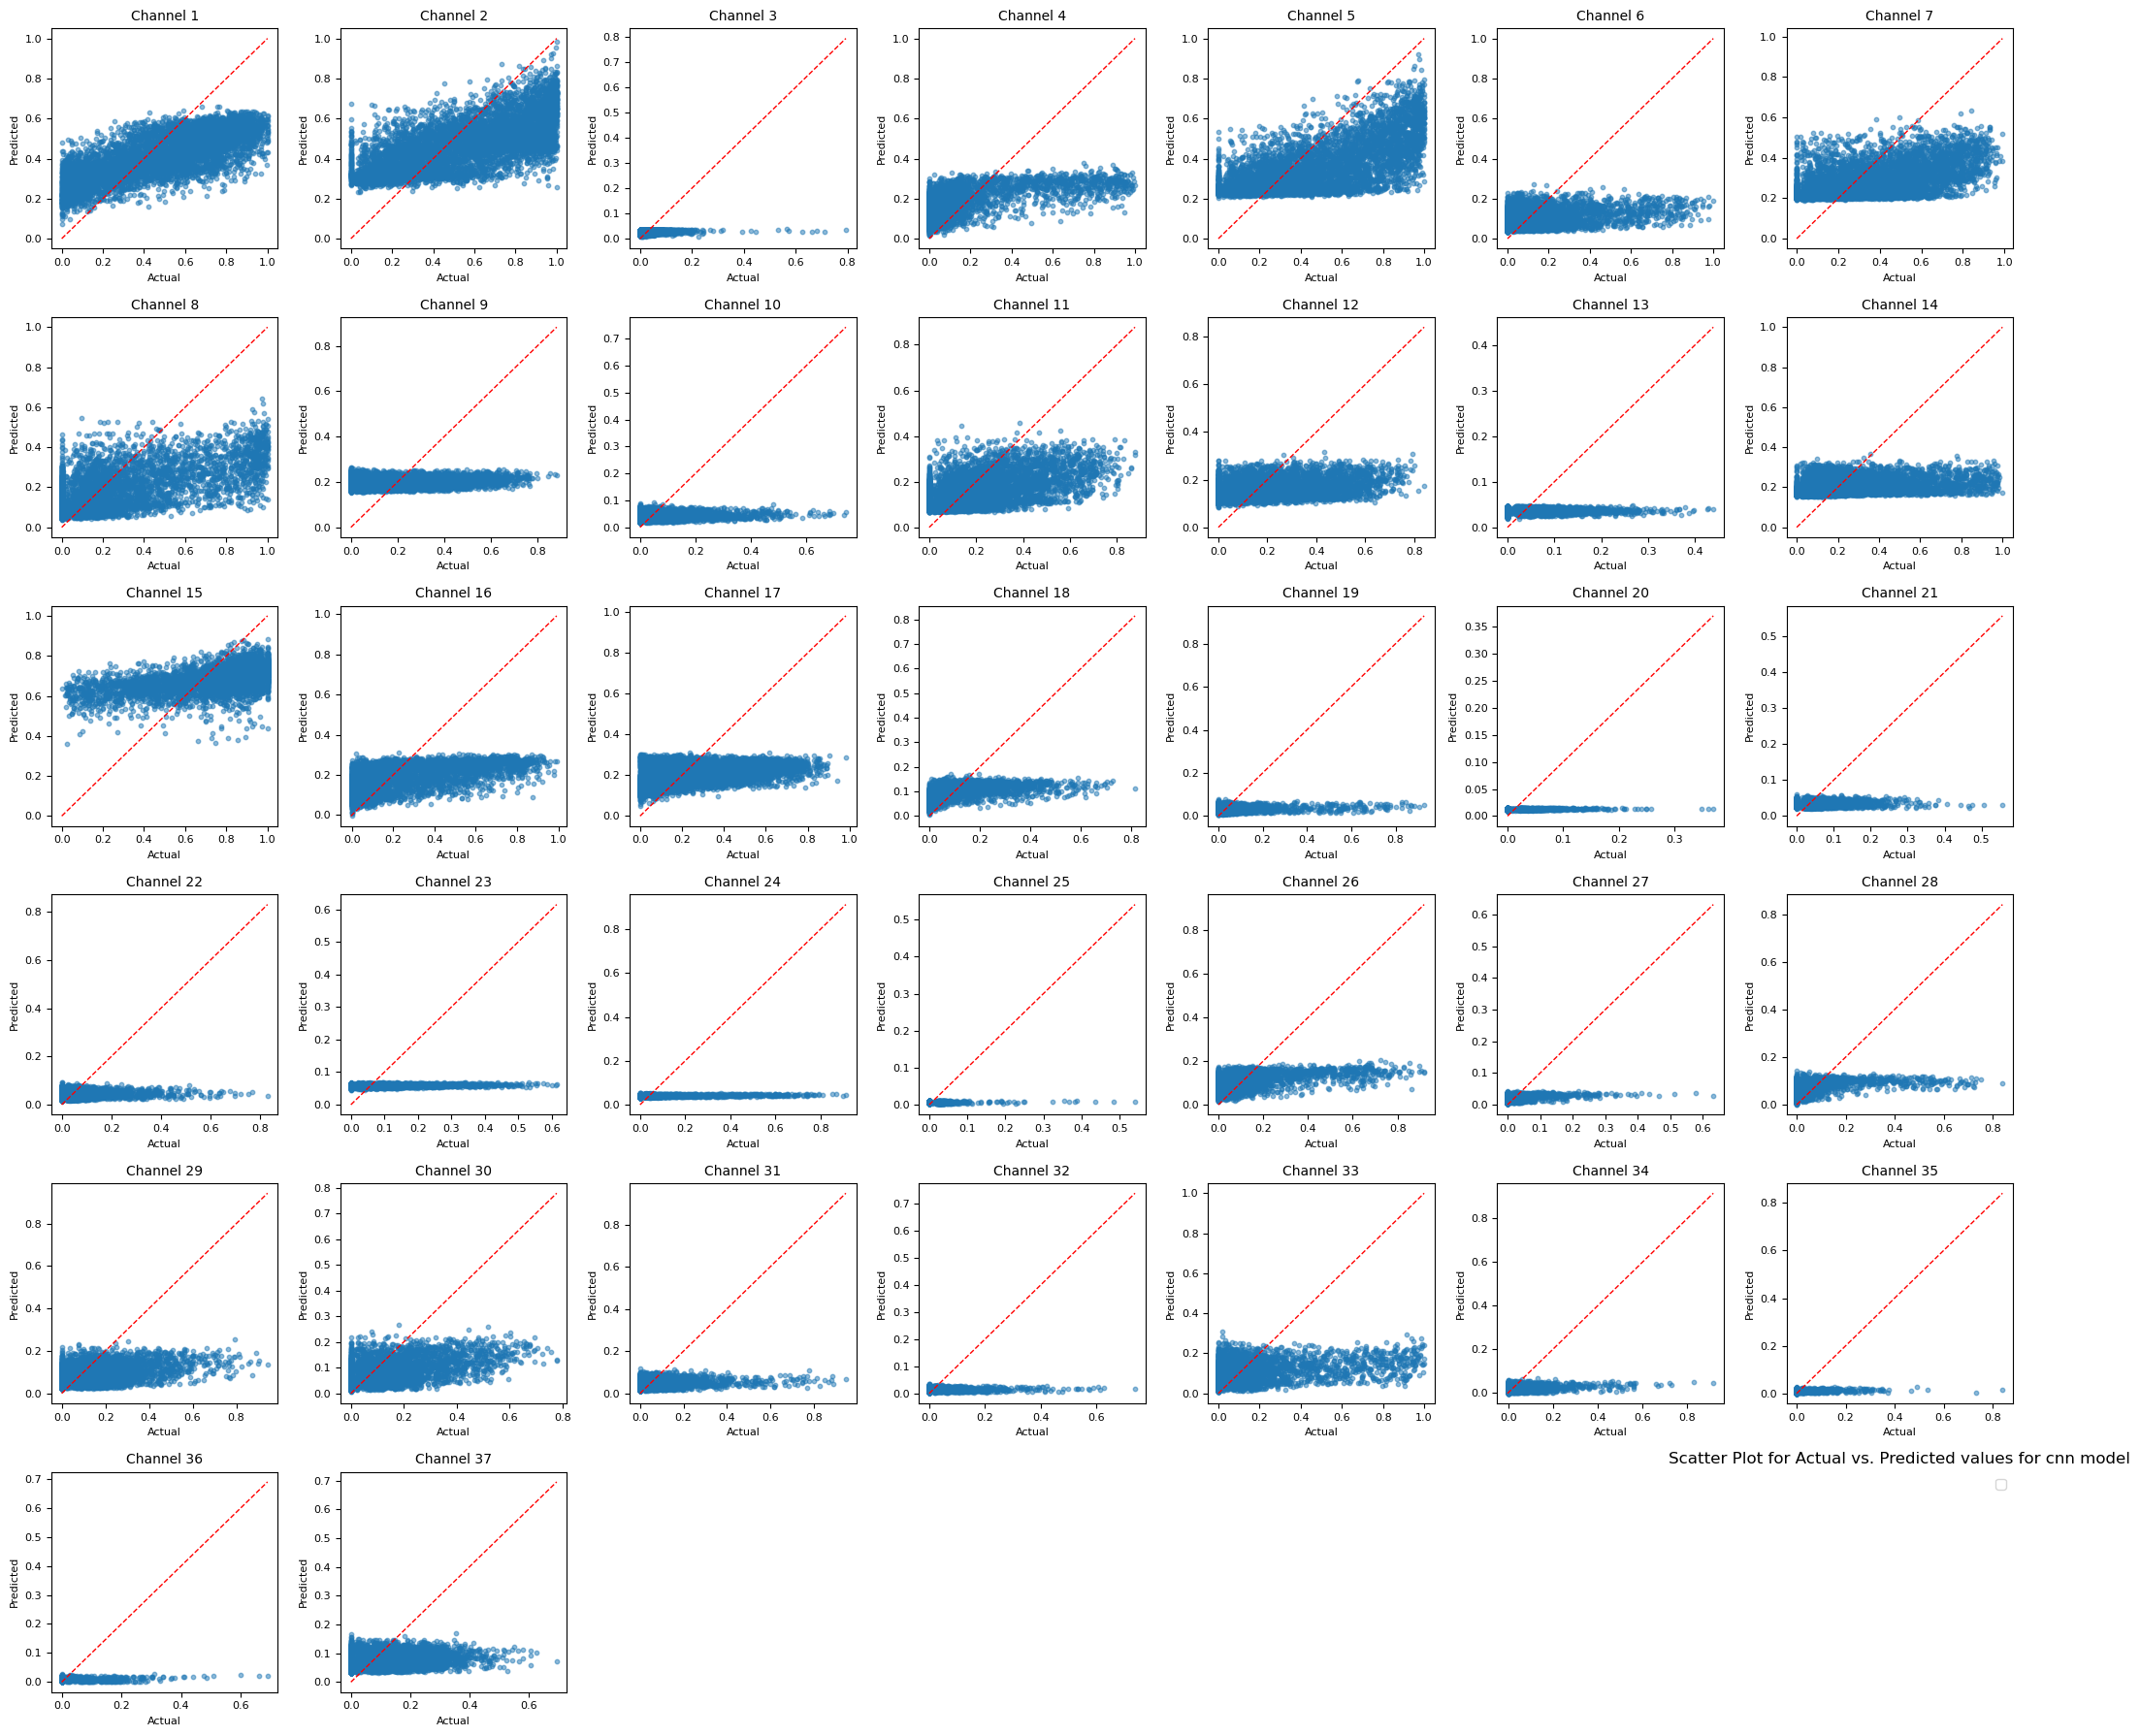

In [99]:
# Evaluation: Collect predictions and actual targets from test set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['image'].to(device).contiguous()
        targets = batch['target'].to(device)
        outputs = model(inputs)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate results from all batches
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Now, you can call your scatter plot function
plot_scatter_all_channels(all_targets, all_preds, model=model_choice)

### Visualiztion

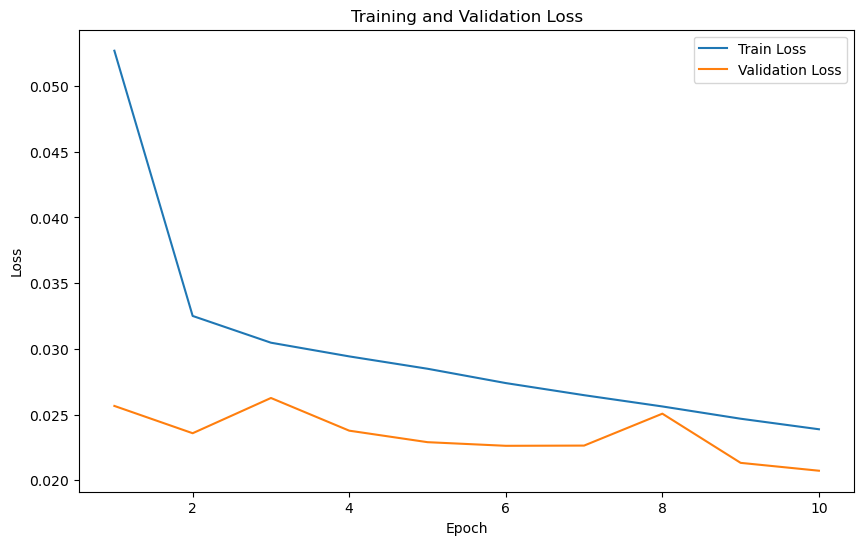

In [100]:
plot_loss_curves(train_losses, val_losses)

In [101]:


if model_choice == "efficientnet" and ver==0:
    loss_curves_dict["EfficientNet-B0"] = (train_losses, val_losses)
elif model_choice == "cnn":
    loss_curves_dict["CNN"] = (train_losses, val_losses)
elif model_choice == "vit" and layer == 16:
    loss_curves_dict["Vision Transformer_16"] = (train_losses, val_losses)
elif model_choice == "vit" and layer == 32:
    loss_curves_dict["Vision Transformer_32"] = (train_losses, val_losses)
elif model_choice == "resnet" and ver == 18:
    loss_curves_dict["ResNet-18"] = (train_losses, val_losses)
elif model_choice == "resnet" and ver == 50:
    loss_curves_dict["ResNet-50"] = (train_losses, val_losses)

### Compute Metrics 

In [102]:
mse, rmse, mae = compute_metrics(model, test_loader, device)
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test MSE: 0.0207
Test RMSE: 0.1438
Test MAE: 0.0895


In [103]:


if model_choice == "efficientnet" and ver == 0:
    eff_test_mse, eff_test_rmse, eff_test_mae = compute_metrics(model, test_loader, device)
    metrics_dict["EfficientNet-B0"] = {
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "test_mse": eff_test_mse,
        "test_rmse": eff_test_rmse,
        "test_mae": eff_test_mae,
        "total_training_time": 49705.8
    }
elif model_choice == "cnn":
    cnn_test_mse, cnn_test_rmse, cnn_test_mae = compute_metrics(model, test_loader, device)
    metrics_dict["CNN"] = {
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "test_mse": cnn_test_mse,
        "test_rmse": cnn_test_rmse,
        "test_mae": cnn_test_mae,
        "total_training_time": 8172.4
    }
elif model_choice == "vit" and layer == 16:
    vit_test_mse, vit_test_rmse, vit_test_mae = compute_metrics(model, test_loader, device)
    metrics_dict["Vision Transformer_16"] = {
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "test_mse": vit_test_mse,
        "test_rmse": vit_test_rmse,
        "test_mae": vit_test_mae,
        "total_training_time": 0
    }
elif model_choice == "vit" and layer == 32:
    vit_32_test_mse, vit_32_test_rmse, vit_32_test_mae = compute_metrics(model, test_loader, device)
    metrics_dict["Vision Transformer_32"] = {
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "test_mse": vit_32_test_mse,
        "test_rmse": vit_32_test_rmse,
        "test_mae": vit_32_test_mae,
        "total_training_time": 0
    }
elif model_choice == "resnet" and ver==18:
    res_test_mse, res_test_rmse, res_test_mae = compute_metrics(model, test_loader, device)
    metrics_dict["ResNet-18"] = {
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "test_mse": res_test_mse,
        "test_rmse": res_test_rmse,
        "test_mae": res_test_mae,
        "total_training_time": 8132.3
    }
elif model_choice == "resnet" and ver ==50:
    res_50_test_mse, res_50_test_rmse, res_50_test_mae = compute_metrics(model, test_loader, device)
    metrics_dict["ResNet-50"] = {
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "test_mse": res_50_test_mse,
        "test_rmse": res_50_test_rmse,
        "test_mae": res_50_test_mae,
        "total_training_time": 14280.5
    }

In [104]:
summary_table = create_summary_table(metrics_dict)
summary_table

,Model,train_loss,val_loss,test_mse,test_rmse,test_mae,total_training_time
0,CNN,0.023880,0.020724,0.020665,0.143752,0.089454,8172.4
1,EfficientNet-B0,0.008038,0.009037,0.009137,0.095585,0.055694,49705.8
2,ResNet-18,0.007712,0.009250,0.009254,0.096198,0.058001,8132.3
3,ResNet-50,0.006849,0.008031,0.008075,0.089862,0.054084,14280.5
4,Vision Transformer_32,0.009138,0.012365,0.012156,0.110255,0.064121,0.0


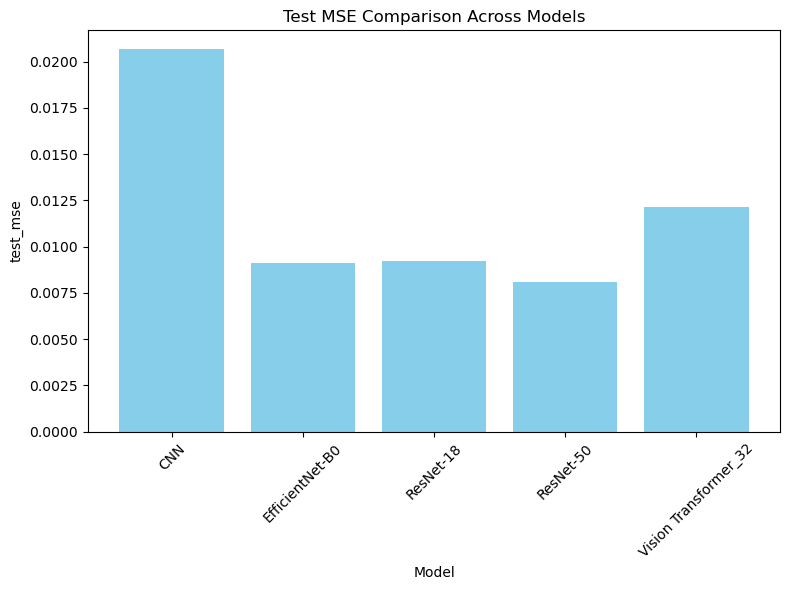

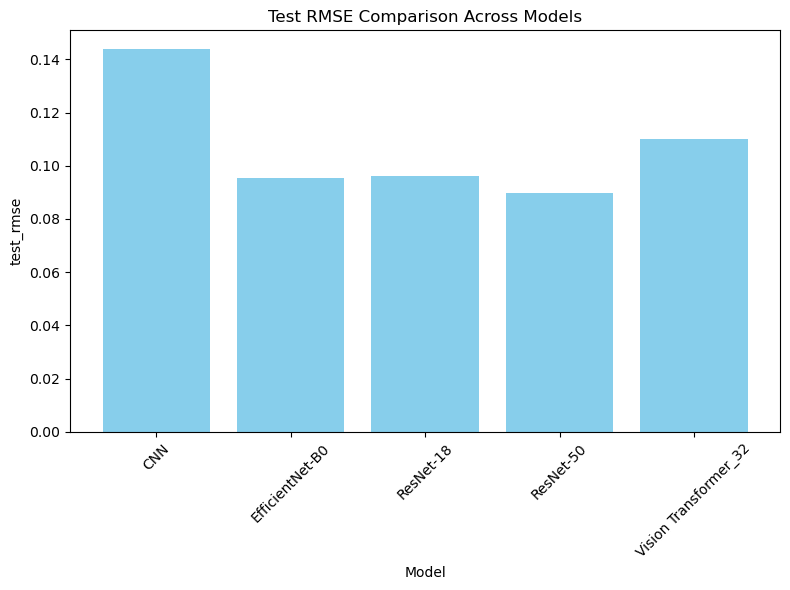

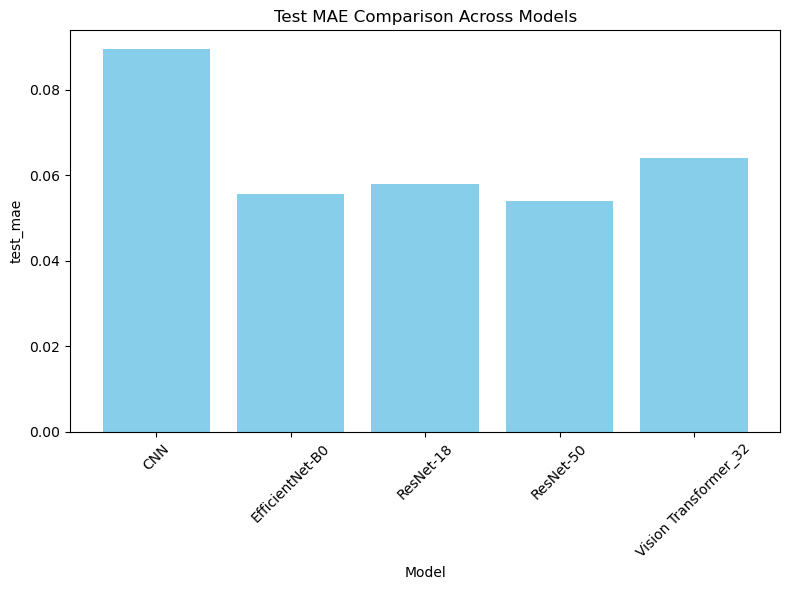

In [105]:


plot_bar_chart(summary_table,"test_mse" , 'Test MSE Comparison Across Models')
plot_bar_chart(summary_table,"test_rmse" , 'Test RMSE Comparison Across Models')
plot_bar_chart(summary_table,"test_mae" , 'Test MAE Comparison Across Models')

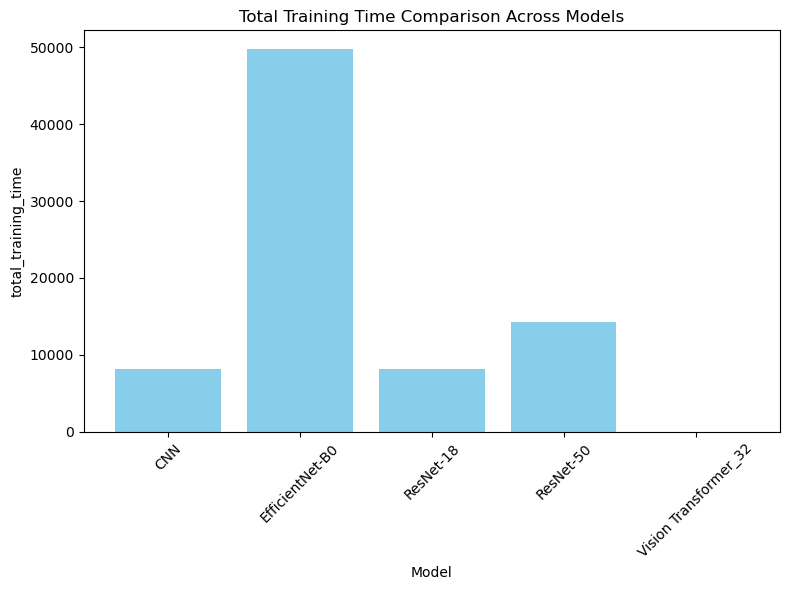

In [106]:
plot_bar_chart(summary_table,"total_training_time" , 'Total Training Time Comparison Across Models')

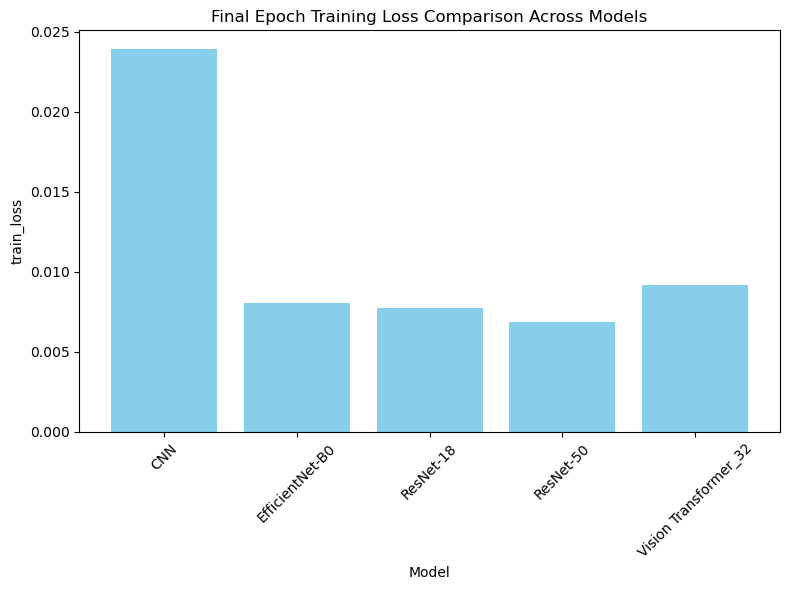

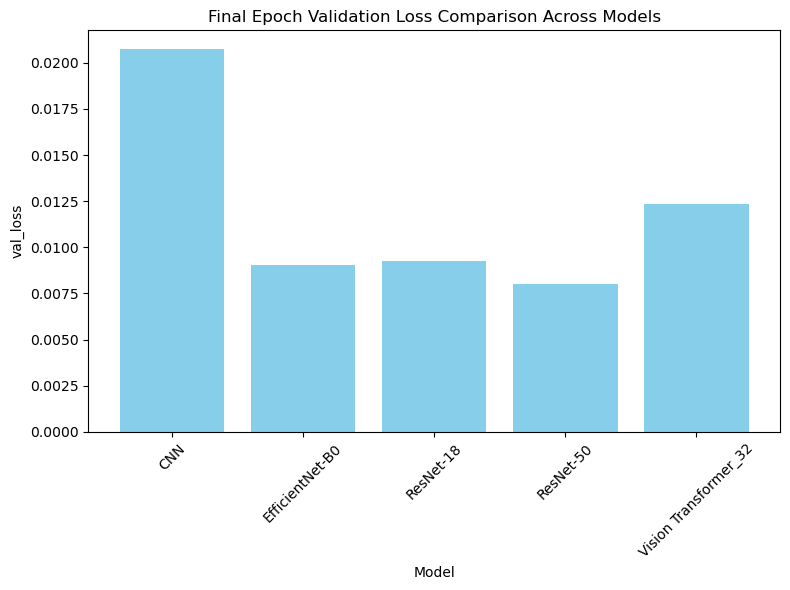

In [107]:
plot_bar_chart(summary_table,"train_loss" , 'Final Epoch Training Loss Comparison Across Models')
plot_bar_chart(summary_table,"val_loss" , 'Final Epoch Validation Loss Comparison Across Models')

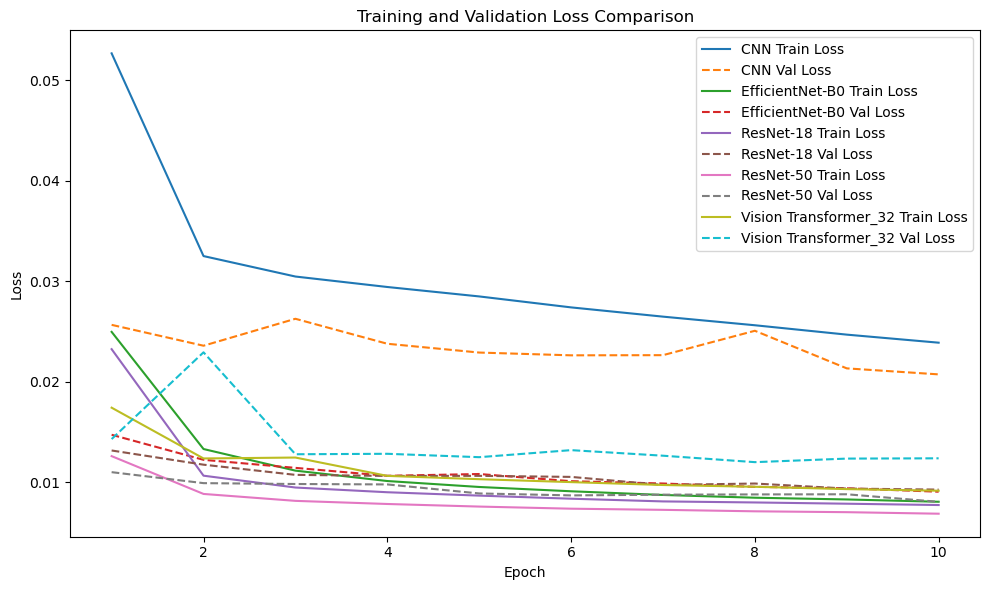

In [108]:
plot_loss_curves_comparison(loss_curves_dict)

In [109]:
# if model_choice == "efficientnet" and ver==0:
#     torch.save(model.state_dict(), 'efficientnet_B0_model_checkpoint.pt')
# elif model_choice == "cnn":
#     torch.save(model.state_dict(), 'CNN_model_checkpoint.pt')
# elif model_choice == "vit" and layer == 16:
#     torch.save(model.state_dict(), 'Vision_Transformer_16_model_checkpoint.pt')
# elif model_choice == "vit" and layer == 32:
#     torch.save(model.state_dict(), 'Vision_Transformer_32_model_checkpoint.pt')
# elif model_choice == "resnet" and ver == 18:
#     torch.save(model.state_dict(), 'ResNet_18_model_checkpoint.pt')
# elif model_choice == "resnet" and ver == 50:
#     torch.save(model.state_dict(), 'ResNet_50_model_checkpoint.pt')